In [20]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from PIL import Image

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms , models

In [25]:
train_path = "/kaggle/input/100-bird-species/train/"
val_path = "/kaggle/input/100-bird-species/valid/"
test_path = "/kaggle/input/100-bird-species/test/"
n_train = len(os.listdir(train_path))
print("The number of classes are" , n_train)

The number of classes are 525


In [ ]:
#Display a random image from the train dataset
fold = np.random.choice(os.listdir(train_path))
all_imgs = os.listdir(train_path + fold)
img_name = np.random.choice(all_imgs)
img = cv2.imread(train_path + fold + "/" + img_name)
img = cv2.cvtColor(img , cv2.COLOR_BGR2RGB)
print("Species:" , fold)
plt.imshow(img)
plt.show()

Species: BANDED PITA


In [ ]:
#Hyperparameters
BATCH_SIZE = 64
LR = 0.001
NUM_EPOCHS = 5

In [ ]:
#Transforms
transform = transforms.Compose([
    transforms.ToTensor() , 
    transforms.Resize((224 , 224) , antialias = True) , 
    transforms.Normalize(mean=[0.485, 0.456, 0.406] , std=[0.229, 0.224, 0.225])
])

In [6]:
#Dataset
train_dataset = torchvision.datasets.ImageFolder(root = train_path , transform = transform)
val_dataset = torchvision.datasets.ImageFolder(root = val_path , transform = transform)
test_dataset = torchvision.datasets.ImageFolder(root = test_path , transform = transform)

In [7]:
#DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset , shuffle = True , batch_size = BATCH_SIZE)
val_loader = torch.utils.data.DataLoader(val_dataset , shuffle = False , batch_size = BATCH_SIZE , drop_last = True)
test_loader = torch.utils.data.DataLoader(test_dataset , shuffle = False , batch_size = BATCH_SIZE)

In [8]:
#Model
model = models.resnet18(pretrained = True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 35.3MB/s]


In [9]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
final_layer_infeatures = model.fc.in_features

In [11]:
model.fc = nn.Linear(final_layer_infeatures , n_train)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [13]:
fin_model = model.to(device)

In [14]:
#Optimizer and Loss function
optimizer = torch.optim.Adam(model.parameters() , lr = LR)
loss_fn = nn.CrossEntropyLoss()

In [15]:
all_train_losses = []
all_val_losses = []

for EPOCH in range(NUM_EPOCHS):
    train_epoch_loss = 0
    total_train_samples = 0
    total_train_correct = 0
    for (images , labels) in train_loader:
        total_train_samples += images.shape[0]
        fin_model.train()
        if torch.cuda.is_available():
            images = images.to(device)
            labels = labels.to(device)
        output = fin_model(images)
        loss = loss_fn(output , labels)
        
        train_epoch_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        fin_model.eval()
        with torch.no_grad():
            _ , indices = torch.max(output , dim = 1)
            total_train_correct += (indices == labels).sum().item()
            
    #Validation
    val_epoch_loss = 0
    total_val_samples = 0
    total_val_correct = 0
    fin_model.eval()
    with torch.no_grad():
        for (images , labels) in val_loader:
            total_val_samples += images.shape[0]
            if torch.cuda.is_available():
                images = images.to(device)
                labels = labels.to(device)
            output = fin_model(images)
            loss = loss_fn(output , labels)

            val_epoch_loss += loss.item()

            
            _ , indices = torch.max(output , dim = 1)
            total_val_correct += (indices == labels).sum().item()
            
            
    train_loss = train_epoch_loss / total_train_samples
    val_loss = val_epoch_loss / total_val_samples
    train_accuracy = total_train_correct / total_train_samples
    val_accuracy = total_val_correct / total_val_samples
    
    all_train_losses.append(train_loss)
    all_val_losses.append(val_loss)
    
    print(train_loss , " " , val_loss , " " , train_accuracy , " " , val_accuracy)

0.028192172917343886   0.01007997161686057   0.6023040113428251   0.8235518292682927
0.00909732980483632   0.006900451728142798   0.8461983812843387   0.879954268292683
0.005911587075093566   0.005941571838154298   0.895007975423879   0.8910060975609756
0.004231740707024177   0.007118022523638679   0.9219353695279731   0.8833841463414634
0.0033216550078681195   0.006322065635198136   0.9376617238731021   0.8929115853658537


In [16]:
#Testing accruacy
total_test_samples = 0
total_test_correct = 0
with torch.no_grad():
    for (images , labels) in test_loader:
        total_test_samples += images.shape[0]
        if torch.cuda.is_available():
            images = images.to(device)
            labels = labels.to(device)
        output = fin_model(images)


        _ , indices = torch.max(output , dim = 1)
        total_test_correct += (indices == labels).sum().item()

In [17]:
total_test_correct / total_test_samples

0.9222857142857143

In [26]:
fold = np.random.choice(os.listdir(test_path))
all_imgs = os.listdir(test_path + fold)
img_name = np.random.choice(all_imgs)

Species: EURASIAN GOLDEN ORIOLE


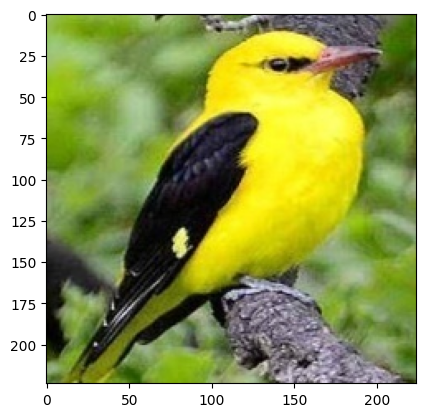

In [27]:
img = cv2.imread(test_path + fold + "/" + img_name)
img = cv2.cvtColor(img , cv2.COLOR_BGR2RGB)
print("Species:" , fold)
plt.imshow(img)
plt.show()

In [28]:
img = Image.open(test_path + fold + "/" + img_name)

In [32]:
with torch.no_grad():
    output = fin_model(transform(img).to(device)[None , ...])

In [35]:
torch.max(output , dim = 1)

torch.return_types.max(
values=tensor([2.3543], device='cuda:0'),
indices=tensor([215], device='cuda:0'))

In [36]:
dir(train_loader)

['_DataLoader__initialized',
 '_DataLoader__multiprocessing_context',
 '_IterableDataset_len_called',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_auto_collation',
 '_dataset_kind',
 '_get_iterator',
 '_index_sampler',
 '_is_protocol',
 '_iterator',
 'batch_sampler',
 'batch_size',
 'check_worker_number_rationality',
 'collate_fn',
 'dataset',
 'drop_last',
 'generator',
 'multiprocessing_context',
 'num_workers',
 'persistent_workers',
 'pin_memory',
 'pin_memory_device',
 'prefetch_factor',
 'sampler',
 'timeout',
 'worker_init_fn']

In [48]:
list(train_dataset.class_to_idx.keys())[215]

'EURASIAN GOLDEN ORIOLE'